<a href="https://colab.research.google.com/github/sfwathen/test-assignment-sfwathen/blob/main/Copy_of_2_1_Analyzing_One_Categorical_Variable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Recall from Chapter 1 that a **categorical variable** is a variable that can take on one of a limited set of values (which are called _levels_). In this chapter, we will discuss ways to analyze categorical variables. Throughout this chapter, we use the Titanic data set as a working example. This data set contains information about all of the people who were aboard the RMS Titanic when it sank in 1912, including both passengers and crew. Let's start by reading in this data set.

In [ ]:
import pandas as pd

data_dir = "http://dlsun.github.io/pods/data/"
df_titanic = pd.read_csv(data_dir + "titanic.csv")
df_titanic

The categorical variables in this data set are:
- `gender` (male or female)
- `class`: what class they were in (1st, 2nd, or 3rd) or what type of crew member they were
- `embarked`: where they embarked (Belfast, Southampton, Cherbourg, or Queenstown)
- `country`: their country of origin
- `ticketno`: the ticket number
- `survived`: whether or not they survived the disaster

Note that `age` and `fare` are quantitative variables. It is tempting to consider `name` a categorical variable, but it is not, since (almost) every person has a unique name. In order for a variable to be categorical, it must take on a _limited_ set of values, ideally with each level appearing multiple times in the data set. Otherwise, the analyses that we describe in this chapter will not be very meaningful.

# Analyzing One Categorical Variable

In this lesson, we focus on a single categorical variable. For a high-level summary of a categorical variable, we can use the `.describe()` command. Note that the behavior of `.describe()` will change, depending on whether `pandas` thinks that the variable is quantitative or categorical, which is why it is important to cast categorical variables to the right type, as we discussed in the previous chapter.

In [ ]:
df_titanic["class"].describe()

To completely summarize a single categorical variable, we report the number of times each level appeared, or its **frequency**.

In [25]:
class_counts = df_titanic["class"].value_counts()
class_counts

3rd                 709
victualling crew    431
engineering crew    324
1st                 324
2nd                 284
restaurant staff     69
deck crew            66
Name: class, dtype: int64

Notice that the levels are sorted in decreasing order of frequency by default. We can also report the levels in the order they appear in the data set...

In [ ]:
df_titanic["class"].value_counts(sort=False)

...or in alphabetical order, by sorting the index:

In [ ]:
class_counts.sort_index()

Note that this produces a _new_ `Series` with the index sorted. It does not sort the original `Series` `class_counts`. To sort the original series, we need to specify that the sorting should be done in place, just like we did for `.set_index()` in Chapter 1.

In [24]:
class_counts.sort_index(inplace=True)
class_counts

NameError: ignored

Any other order would require selecting the levels manually, in the desired order.

In [36]:
cf = class_counts.loc[
    ["1st", "2nd", "3rd",
     "deck crew", "engineering crew", "victualling crew",
     "restaurant staff"]
]

This information can be visualized using a **bar chart**.

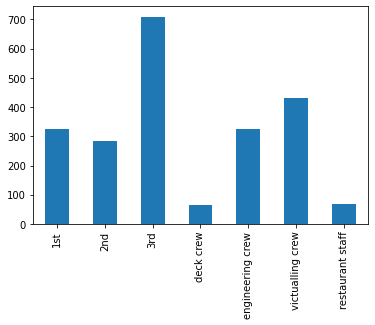

In [37]:
cf.plot.bar()

Instead of reporting counts, we can also report proportions or probabilities, or the **relative frequencies**. We can calculate the relative frequencies by specifying `normalize=True` in `.value_counts()`.

In [28]:
class_probs = df_titanic["class"].value_counts(normalize=True)
class_probs.sort_index()

1st                 0.146806
2nd                 0.128681
3rd                 0.321251
deck crew           0.029905
engineering crew    0.146806
restaurant staff    0.031264
victualling crew    0.195288
Name: class, dtype: float64

This is equivalent to taking the counts and dividing by their sum.

In [26]:
class_counts / class_counts.sum()

3rd                 0.321251
victualling crew    0.195288
engineering crew    0.146806
1st                 0.146806
2nd                 0.128681
restaurant staff    0.031264
deck crew           0.029905
Name: class, dtype: float64

Notice that the relative frequencies add up to 1.0, by construction. We can report these relative frequencies using probability notation. For example:

$$ P(\text{1st class}) = 0.146806. $$

The complete collection of probabilities of all levels of a variable is called the **distribution** of that variable. So the code above calculates the distribution of "class" on the Titanic.

The bar chart for relative frequencies (i.e., probabilities) looks qualitatively the same as the bar chart for frequencies (i.e., counts). The only difference is that the scale on the $y$-axis is different.

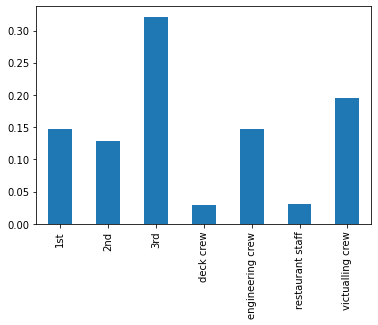

In [29]:
class_probs.sort_index().plot.bar()

In the next lesson, we will see why it is often more useful to plot the relative frequencies (i.e., probabilities) rather than the frequencies (i.e., counts).

## Transforming Categorical Variables

A categorical variable can be transformed by mapping its levels to new levels. For example, we may only be interested in whether a person on the titanic was a passenger or a crew member. The variable `class` is too detailed. We can create a new variable, `type`, that is derived from the existing variable `class`. Observations with a `class` of "1st", "2nd", or "3rd" get a value of "passenger", while observations with a `class` of "deck crew", "engineering crew", or "deck crew" get a value of "crew".

In [ ]:
df_titanic["type"] = df_titanic["class"].map({
    "1st": "passenger",
    "2nd": "passenger",
    "3rd": "passenger",
    "victualling crew": "crew",
    "engineering crew": "crew",
    "deck crew": "crew"
})

df_titanic

Upon closer inspection of this `DataFrame`, we see that we accidentally left out the level "restaurant staff" in the input to `.map()`. Any levels that are unspecified will be mapped to the missing value `NaN`.

This suggests a more concise way to define the new variable `type`. We can specify only the levels for passengers in the mapping and then fill in the missing values afterwards.

In [ ]:
df_titanic["type"] = df_titanic["class"].map({
    "1st": "passenger",
    "2nd": "passenger",
    "3rd": "passenger"
})

# Replace all missing values by "crew"
df_titanic["type"].fillna("crew", inplace=True)

df_titanic

For more complex mappings, the `.map()` method also accepts a function. So the above 

In [ ]:
def class_to_type(c):
  if c in ["1st", "2nd", "3rd"]:
    return "passenger"
  else:
    return "crew"

df_titanic["class"].map(class_to_type)

We can apply the techniques we learned above to calculate the _distribution_ of this new variable, which only has two levels.

In [ ]:
df_titanic["type"].value_counts(normalize=True)

## Conditional Probabilities

What fraction of males were crew members? To answer questions like this, we have to filter the `DataFrame` to include only males.

The standard way to filter a `DataFrame` is to use a **boolean mask**. A boolean mask is simply a `Series` of booleans whose index matches the index of the `DataFrame`.

The easiest way to create a boolean mask is to use one of the standard comparison operators `==`, `<`, `>`, and `!=` on an existing column in the `DataFrame`. For example, the following code produces a boolean mask that is equal to `True` for the males on the Titanic and `False` otherwise.

In [ ]:
df_titanic["gender"] == "male"

Notice the subtle way the equality operator `==` is being used here! We are comparing an array with a string, i.e.,

\begin{align}
& \begin{bmatrix} \text{"male"} \\ \text{"male"} \\ \text{"male"} \\ \text{"female"} \\ \vdots \\ \text{"male"} \end{bmatrix} & \text{with} & & \text{"male"}.
\end{align}

In most programming languages, this comparison would make no sense. An array of strings is obviously not equal to a string. However, `pandas` automatically applies the equality operator to _each_ element of the array. As a result, we get an entire array (i.e., a `Series`) of booleans.

\begin{align}
 \begin{bmatrix} \text{"male"} \\ \text{"male"} \\ \text{"male"} \\ \text{"female"} \\ \vdots \\ \text{"male"} \end{bmatrix} &== \text{"male"} &\Longrightarrow & &  \begin{bmatrix} \text{True} \\ \text{True} \\ \text{True} \\ \text{False} \\ \vdots \\ \text{True} \end{bmatrix}.
\end{align}

When an operation is applied to each element of an array, it is said to be **broadcast** over that array.

Now, we can use the boolean mask as a filter on the `DataFrame` to extract the rows where the mask equals `True`.

In [ ]:
df_male = df_titanic[df_titanic["gender"] == "male"]
df_male

Note that every person in this new `DataFrame` is male. If you inspect the index, you will see that rows 4 and 5 are missing. That is because those passengers were female.

Finally, we can apply the methods we've learned in this lesson to `df_male` to answer the original question: "What fraction of males were crew members?"

In [ ]:
df_male["type"].value_counts(normalize=True)

It appears that about 50.4657% of the males were crew members. We can notate this using _conditional probability_ notation:

$$ P(\text{crew} | \text{male}) = 0.504657. $$

The bar $|$ is read as "given". The information after the bar is the given information. In this case, we were interested in the probability a person was a crew member, "given" they were male. That is, after restricting to the male passengers (i.e., using a boolean mask as a filter), we want to know the relative frequency of crew members.

We can also filter on multiple criteria. For example, if we want to know the fraction of male _survivors_ who were crew members, we need to combine two boolean masks, one based on the column `gender` and another based on the column `survived`. The two masks can be combined using the logical operator `&`.

In [ ]:
(df_titanic["gender"] == "male") & (df_titanic["survived"] == 1)

Notice that the logical operator was _broadcast_ (that word again!) over the elements of the two `Series`. In other words, the logical operator was applied to each element, producing a `Series` of booleans.

Now we can use this new boolean mask to filter the `DataFrame`, just as we did before.

In [3]:
df_male_survivors = df_titanic[(df_titanic["gender"] == "male") & (df_titanic["survived"] == 1)]
df_male_survivors

,name,gender,age,class,embarked,country,ticketno,fare,survived,type
5,"Abelseth, Mr. Olaus Jørgensen",male,25.000000,3rd,S,United States,348122.0,7.1300,1,passenger
8,"Abī-Al-Munà, Mr. Nāsīf Qāsim",male,27.000000,3rd,C,Lebanon,2699.0,18.1509,1,passenger
9,"Abrahamsson, Mr. Abraham August Johannes",male,20.000000,3rd,S,Finland,3101284.0,7.1806,1,passenger
13,"Aks, Master. Frank Philip",male,0.833333,3rd,S,England,392091.0,9.0700,1,passenger
22,"Allison, Master. Hudson Trevor",male,0.916667,1st,S,Canada,113781.0,151.1600,1,passenger
...,...,...,...,...,...,...,...,...,...,...
2185,"Windebank, Mr. Alfred Edgar",male,38.000000,victualling crew,S,England,NaN,NaN,1,crew
2188,"Witter, Mr. James William Cheetham",male,31.000000,victualling crew,S,England,NaN,NaN,1,crew
2200,"Wright, Mr. William",male,40.000000,victualling crew,S,England,NaN,NaN,1,crew
2202,"Wynn, Mr. Walter",male,41.000000,deck crew,B,England,NaN,NaN,1,crew


Besides `&`, there are two other logical operators that can be used to modify and combine boolean masks.

- `&` means "and"
- `|` means "or"
- `~` means "not"

Like `&`, the operators `|` and `~` are broadcast over the boolean masks.

## Exercises

_Exercises 1-2 ask you to continue working with the Titanic data set explored in this lesson._

1\. What proportion of crew members were male? Express your answer using probability notation. How does this proportion differ from the proportion that was calculated in the lesson?

In [61]:
df_crew = df_titanic[(df_titanic["type"] == "crew")]
df_crew["gender"].value_counts(normalize=True)

male      0.974157
female    0.025843
Name: gender, dtype: float64

The proportion of crew members that were male is P(male|crew) = 0.974157. This is different than the amount of males that are crew members significantly, as P(crew|male) = 0.504657

2\. What is the distribution of gender among passengers on the Titanic? What is the distribution of gender among passengers on the Titanic who survived? Express your answers using probability notation.

In [30]:
df_passengers = df_titanic[(df_titanic["type"] == "passenger")]
df_passengers["gender"].value_counts(normalize=True)

male      0.646166
female    0.353834
Name: gender, dtype: float64

The distribution of gender among passengers on the Titanic was P(male|passenger) = 0.646166 and P(female|passenger) = 0.353834

In [19]:
df_passengers_survived = df_titanic[(df_titanic["type"] == "passenger") & (df_titanic["survived"] == 1)]
df_passengers_survived["gender"].value_counts(normalize=True)

female    0.678
male      0.322
Name: gender, dtype: float64

The gender distribution of passengers that survived on the titanic was P(male|passenger, survived) = 0.322 and P(female|passenger, survived) = 0.678

_Exercises 3-5 deal with the OKCupid data set, which consists of user profiles in the San Francisco Bay Area on the dating website OKCupid. This data set is available at the URL https://dlsun.github.io/pods/data/okcupid.csv._

3\. Make a visualization of the distribution of drinking status.

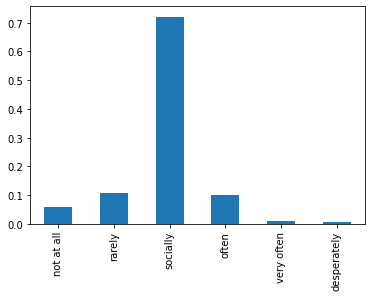

In [59]:
import pandas as pd

data_dir = "http://dlsun.github.io/pods/data/"
df_okcupid = pd.read_csv(data_dir + "okcupid.csv")

drink_counts = df_okcupid["drinks"].value_counts(normalize="true")

drinks_sorted = drink_counts.loc[["not at all", "rarely", "socially",
     "often", "very often", "desperately"]]

drinks_sorted.plot.bar()

4\. Create a new variable that indicates whether the user has, likes, or dislikes cats. Visualize the distribution of this variable.

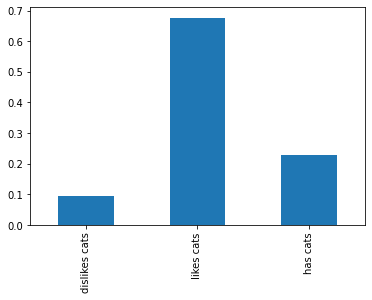

In [60]:
petsNaN = pd.isna(df_okcupid["pets"])
df_pets = df_okcupid[~petsNaN]

df_okcupid["cats"] = df_okcupid["pets"].map({
    "dislikes dogs and likes cats": "likes cats",
    "likes cats": "likes cats",
    "likes dogs and likes cats": "likes cats",

    "dislikes dogs and dislikes cats": "dislikes cats",
    "dislikes cats": "dislikes cats",
    "likes dogs and dislikes cats": "dislikes cats",
    
    "dislikes dogs and has cats": "has cats",
    "has cats": "has cats",
    "likes dogs and has cats": "has cats",
})

df_cats = df_okcupid["cats"].value_counts(normalize = "true")

df_cats_sorted = df_cats.loc[["dislikes cats", "likes cats", "has cats"]]

df_cats_sorted.plot.bar()

5\. If you were a heterosexual female interested in dating a non-smoker, how many options would you have in this data set?

In [58]:
df_options = df_okcupid[(df_okcupid["sex"] == "m")]
df_options["smokes"].value_counts()

no                1281
sometimes          113
when drinking       91
yes                 60
trying to quit      55
Name: smokes, dtype: int64

From this data set you would have 1281 options for males that do not smoke. 